In [25]:
from psycopg2 import connect as pgconnect
import snowflake.connector
import pandas as pd
import string

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,20)

In [200]:
# recipe_all = pd.read_csv('/Users/xun/Documents/Thesis/recipe_data/recipe_data_processed.csv')
recipe_all = pd.read_csv('/Users/xun/RSS/Thesis/recipe_data/recipe_data_processed.csv')
recipe_all.shape # (2060, 15)

(1522, 12)

In [193]:
recipe_all.head()

,publishdate,content_id,title_en,cuisine,difficulty,mealtype,diettype,cooking_method,steps,ingredients,#ingredients,steps_length
0,2017-04-29,R702,Braised chicken with couscous,african,medium,main,non-vegetarian,"marinating,roasting,slow-cooking,steaming",Deglaze with some of the chicken stock. In the...,"['chicken legs', 'chicken stock (divided)', 'c...",18,158
1,2017-11-05,R943,Lamb and quince tagine,african,medium,main,non-vegetarian,NaN,Heat olive oil and butter in a tagine or large...,"['butter', 'cilantro for garnishing', 'ground ...",17,87
2,2018-07-24,R1295,East African-style coconut chicken,african,medium,main,non-vegetarian,sauteing,"Add the onions, garlic, and ginger to the pot ...","['canned crushed tomatoes', 'chicken legs', 'c...",18,220
3,2017-02-02,R574,Moroccan-inspired chickpea stew,african,easy,main,vegetarian,stewing,Add chickpeas to stew and let simmer for appro...,"['apple cider vinegar (optional)', 'black pepp...",29,188
4,2015-06-29,R256,Coleslaw with cranberries,american,easy,others,vegetarian,marinating,Finely chop parsley. Roughly chop cranberries....,"['buttermilk', 'cabbage', 'carrots', 'cranberr...",12,69


In [30]:
recipe_text = recipe_all[['steps']]

In [33]:
recipe_text.head()
type(recipe_text)

,steps
0,Deglaze with some of the chicken stock. In the...
1,Heat olive oil and butter in a tagine or large...
2,"Add the onions, garlic, and ginger to the pot ..."
3,Add chickpeas to stew and let simmer for appro...
4,Finely chop parsley. Roughly chop cranberries....


pandas.core.frame.DataFrame

In [45]:
import spacy
# !python3 -m spacy download en_core_web_md
nlp  = spacy.load('/usr/local/lib/python3.7/site-packages/en_core_web_md/en_core_web_md-2.1.0')


In [50]:
# With spaCy loaded, the documents can be lemmatised.

def keep_token(t):
    return (t.is_alpha and 
            not (t.is_space or t.is_punct or 
                 t.is_stop or t.like_num))

def lemmatize_doc(doc):
    return [ t.lemma_ for t in doc if keep_token(t)]


In [53]:
recipe_text['steps'] = recipe_text['steps'].apply(lambda x: lemmatize_doc(nlp(x)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
recipe_text.head()

,steps
0,"[deglaze, chicken, stock, meantime, wash, bell..."
1,"[heat, olive, oil, butter, tagine, large, sauc..."
2,"[add, onion, garlic, ginger, pot, sauté, appro..."
3,"[add, chickpea, stew, let, simmer, approx, min..."
4,"[finely, chop, parsley, roughly, chop, cranber..."


In [77]:
from tqdm import tqdm
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [78]:
vocab = build_vocab(recipe_text.steps.tolist())
import operator
sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)


100%|██████████| 1522/1522 [00:00<00:00, 68763.53it/s]


[('add', 4080),
 ('approx', 3319),
 ('min', 3109),
 ('heat', 2245),
 ('salt', 1895)]

In [91]:
sorted_vocab[:10]
# sorted_vocab[-10:]

[('add', 4080),
 ('approx', 3319),
 ('min', 3109),
 ('heat', 2245),
 ('salt', 1895),
 ('bowl', 1591),
 ('pan', 1555),
 ('pepper', 1405),
 ('oven', 1368),
 ('oil', 1246)]

In [58]:
# Next, the Gensim package can be used to create 
# a dictionary and filter out stop and infrequent words (lemmas)
# !pip3 install gensim
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

In [59]:
# docs_dict = Dictionary(recipe_text.steps.tolist())

In [97]:
# get term(word) dictionary, give each term a unique ID
docs_dict = Dictionary(recipe_text.steps)
# remove words that appear in less than 2 recipes and top 10 frequent words
docs_dict.filter_n_most_frequent(10)
docs_dict.filter_extremes(no_below=2)
docs_dict.compactify()

In [117]:
print(docs_dict)
docs_dict.token2id

Dictionary(2111 unique tokens: ['Garnish', 'bag', 'bell', 'brown', 'carefully']...)


{'Garnish': 0,
 'bag': 1,
 'bell': 2,
 'brown': 3,
 'carefully': 4,
 'chicken': 5,
 'cinnamon': 6,
 'cold': 7,
 'continue': 8,
 'couscous': 9,
 'cover': 10,
 'cumin': 11,
 'cut': 12,
 'deep': 13,
 'deglaze': 14,
 'directly': 15,
 'drain': 16,
 'dry': 17,
 'freezer': 18,
 'fry': 19,
 'garlic': 20,
 'golden': 21,
 'high': 22,
 'honey': 23,
 'juice': 24,
 'large': 25,
 'leg': 26,
 'lemon': 27,
 'let': 28,
 'lid': 29,
 'marinade': 30,
 'marinate': 31,
 'meantime': 32,
 'medium': 33,
 'mix': 34,
 'onion': 35,
 'overnight': 36,
 'paprika': 37,
 'parsley': 38,
 'peel': 39,
 'pepper': 40,
 'place': 41,
 'raisin': 42,
 'rapeseed': 43,
 'refrigerator': 44,
 'remain': 45,
 'rinse': 46,
 'seal': 47,
 'season': 48,
 'seed': 49,
 'side': 50,
 'simmer': 51,
 'slice': 52,
 'smooth': 53,
 'spicy': 54,
 'stock': 55,
 'strip': 56,
 'tagine': 57,
 'toss': 58,
 'turmeric': 59,
 'wash': 60,
 'water': 61,
 'butter': 62,
 'cilantro': 63,
 'core': 64,
 'desire': 65,
 'dice': 66,
 'finely': 67,
 'ginger': 68,
 

In [92]:
# print(docs_dict.token2id)

In [101]:
docs = recipe_text.steps.tolist()

In [102]:
# get TF-IDF Matrix
import numpy as np
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
docs_tfidf  = model_tfidf[docs_corpus]
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [129]:
recipe_all.steps[0]
docs[0]


'Deglaze with some of the chicken stock. In the meantime, wash bell peppers. Remove seeds and cut into strips. Rinse raisins under cold water. Add cut bell peppers, raisins, couscous, and remaining chicken stock to tagine, cover, and continue to simmer for approx. 10 min. Peel and slice onions and garlic. Remove chicken legs from marinade and carefully drain. Heat oil in the bottom of the tagine over medium-high heat. Add chicken legs, garlic, and onion and fry until deep golden-brown on all sides. Place the lid on the tagine. Let simmer for approx. 80 min. Season with lemon juice, salt, and pepper. Garnish with parsley. Serve directly in the tagine. Enjoy! Wash and dry chicken legs. Mix a part of rapeseed oil with honey until smooth. Add turmeric, cumin, cinnamon, spicy paprika, salt, and pepper. In a large bowl or a freezer bag, toss chicken legs in marinade. Seal or cover and marinate overnight in the refrigerator.'

['deglaze',
 'chicken',
 'stock',
 'meantime',
 'wash',
 'bell',
 'pepper',
 'remove',
 'seed',
 'cut',
 'strip',
 'rinse',
 'raisin',
 'cold',
 'water',
 'add',
 'cut',
 'bell',
 'pepper',
 'raisin',
 'couscous',
 'remain',
 'chicken',
 'stock',
 'tagine',
 'cover',
 'continue',
 'simmer',
 'approx',
 'min',
 'peel',
 'slice',
 'onion',
 'garlic',
 'remove',
 'chicken',
 'leg',
 'marinade',
 'carefully',
 'drain',
 'heat',
 'oil',
 'tagine',
 'medium',
 'high',
 'heat',
 'add',
 'chicken',
 'leg',
 'garlic',
 'onion',
 'fry',
 'deep',
 'golden',
 'brown',
 'side',
 'place',
 'lid',
 'tagine',
 'let',
 'simmer',
 'approx',
 'min',
 'season',
 'lemon',
 'juice',
 'salt',
 'pepper',
 'Garnish',
 'parsley',
 'serve',
 'directly',
 'tagine',
 'enjoy',
 'wash',
 'dry',
 'chicken',
 'leg',
 'mix',
 'rapeseed',
 'oil',
 'honey',
 'smooth',
 'add',
 'turmeric',
 'cumin',
 'cinnamon',
 'spicy',
 'paprika',
 'salt',
 'pepper',
 'large',
 'bowl',
 'freezer',
 'bag',
 'toss',
 'chicken',
 'leg',
 

In [131]:
len(docs_corpus)
print(docs_corpus)

1522

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 6), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 4), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 4), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 4), (58, 1), (59, 1), (60, 2), (61, 1)], [(0, 1), (6, 1), (12, 2), (23, 1), (24, 1), (25, 1), (28, 1), (33, 2), (35, 2), (39, 2), (40, 1), (48, 1), (49, 2), (51, 1), (57, 1), (59, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 3), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1)], [(0, 1), (2, 2), (3, 1), (5, 6), (6, 1), (10, 1), (11, 1), (12, 2), (16, 1), (19

In [116]:
# docs_vecs is the TF-IDF Matrix, with 1522 rows (docs) and 2111 columns (word terms)
docs_vecs.shape
type(docs_vecs)

(1522, 2111)

numpy.ndarray

In [120]:
# Next, we use spaCy to get the 300 dimensional Glove embedding vector 
# for each TF-IDF term.
# nlp(text).vector
tfidf_emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])


(2111, 300)

In [121]:
# tfidf_emb_vecs matrix has 2111 rows (terms) and 300 columns (Glove vectors).
tfidf_emb_vecs.shape

(2111, 300)

In [119]:
nlp('chicken').vector

array([-5.5198e-01, -6.6880e-02,  5.0020e-01,  2.4078e-01,  1.8101e-01,
        1.2851e+00, -2.7813e-01, -1.4746e-01,  7.4014e-01,  1.3283e+00,
       -7.6292e-01,  3.6189e-01, -4.1380e-01, -1.4777e-01,  2.6044e-01,
       -1.0949e-01,  1.8378e-03,  1.4247e+00, -1.3318e-01,  2.4717e-01,
       -1.2421e-01, -1.6584e-02, -6.0407e-02, -1.1245e-02,  4.8592e-02,
       -5.3817e-01, -8.0303e-01, -4.2700e-02,  2.6830e-01, -8.0375e-01,
       -1.7937e-01,  3.1699e-01,  4.5576e-01, -5.3542e-01,  4.2418e-01,
        4.0002e-01, -2.6668e-02, -5.6718e-02,  8.1702e-03,  1.1256e+00,
       -1.6791e-01, -5.1331e-02,  1.4061e-02, -1.5749e-01,  2.4581e-02,
        1.9674e-01, -1.3047e-01,  2.9933e-01,  5.3537e-02,  4.0032e-01,
        5.4849e-02,  1.6346e-02, -3.5284e-02, -1.3605e-01,  2.7789e-01,
       -2.0906e-01,  6.5580e-01,  4.7090e-01,  2.1128e-01,  8.7316e-01,
        2.0089e-01,  2.1248e-02,  1.4408e-01,  2.6658e-01,  2.8882e-01,
       -1.0161e+00,  3.9470e-01,  9.3844e-02, -1.1928e-01,  4.04

In [122]:
# To get a TF-IDF weighted Glove vector summary of each document, 
# we just need to matrix multiply docs_vecs with tfidf_emb_vecs.

docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 

In [123]:
# docs_emb is a matrix with 1522 rows (docs) and 300 columns (Glove vectors as word embeddings)
docs_emb.shape


(1522, 300)

In [132]:
from sklearn.decomposition import PCA
docs_pca = PCA(n_components=8).fit_transform(docs_emb)

In [133]:
docs_pca.shape

(1522, 8)

In [134]:
from sklearn import manifold

tsne = manifold.TSNE()
viz = tsne.fit_transform(docs_pca)

In [165]:
viz.shape
viz

(1522, 2)

array([[ -9.19976  ,  30.118479 ],
       [ -2.4261434,  23.141823 ],
       [-18.494204 ,   3.6970284],
       ...,
       [-45.612766 ,   4.5684576],
       [-14.252046 ,  27.244764 ],
       [-32.864708 ,  21.230526 ]], dtype=float32)

In [142]:
len(np.where(recipe_all.diettype == 'vegetarian')[0])
len(np.where(recipe_all.diettype == 'non-vegetarian')[0])

831

691

In [171]:
np.where(recipe_all.diettype == 'vegetarian')[0]

array([   3,    4,    7,    8,   10,   12,   13,   16,   18,   19,   20,
         21,   22,   23,   24,   25,   29,   32,   33,   34,   36,   37,
         38,   39,   40,   42,   43,   44,   45,   46,   48,   51,   52,
         54,   58,   59,   60,   64,   66,   67,   69,   70,   72,   74,
         76,   79,   81,   82,   83,   84,   86,   88,   89,   91,   92,
         95,   98,   99,  101,  103,  105,  107,  108,  111,  114,  115,
        116,  117,  118,  120,  122,  124,  126,  127,  128,  131,  132,
        133,  134,  135,  136,  138,  139,  141,  144,  145,  148,  149,
        150,  151,  152,  154,  156,  159,  162,  163,  164,  165,  166,
        167,  169,  170,  171,  172,  173,  175,  176,  177,  178,  182,
        183,  186,  188,  189,  190,  193,  194,  196,  198,  199,  200,
        203,  205,  206,  208,  209,  210,  212,  213,  215,  217,  218,
        220,  223,  227,  228,  233,  234,  237,  240,  250,  251,  252,
        255,  257,  261,  267,  269,  271,  272,  2

Text(0.5, 1.0, 't-SNE Projection of the Recipe Embedding')

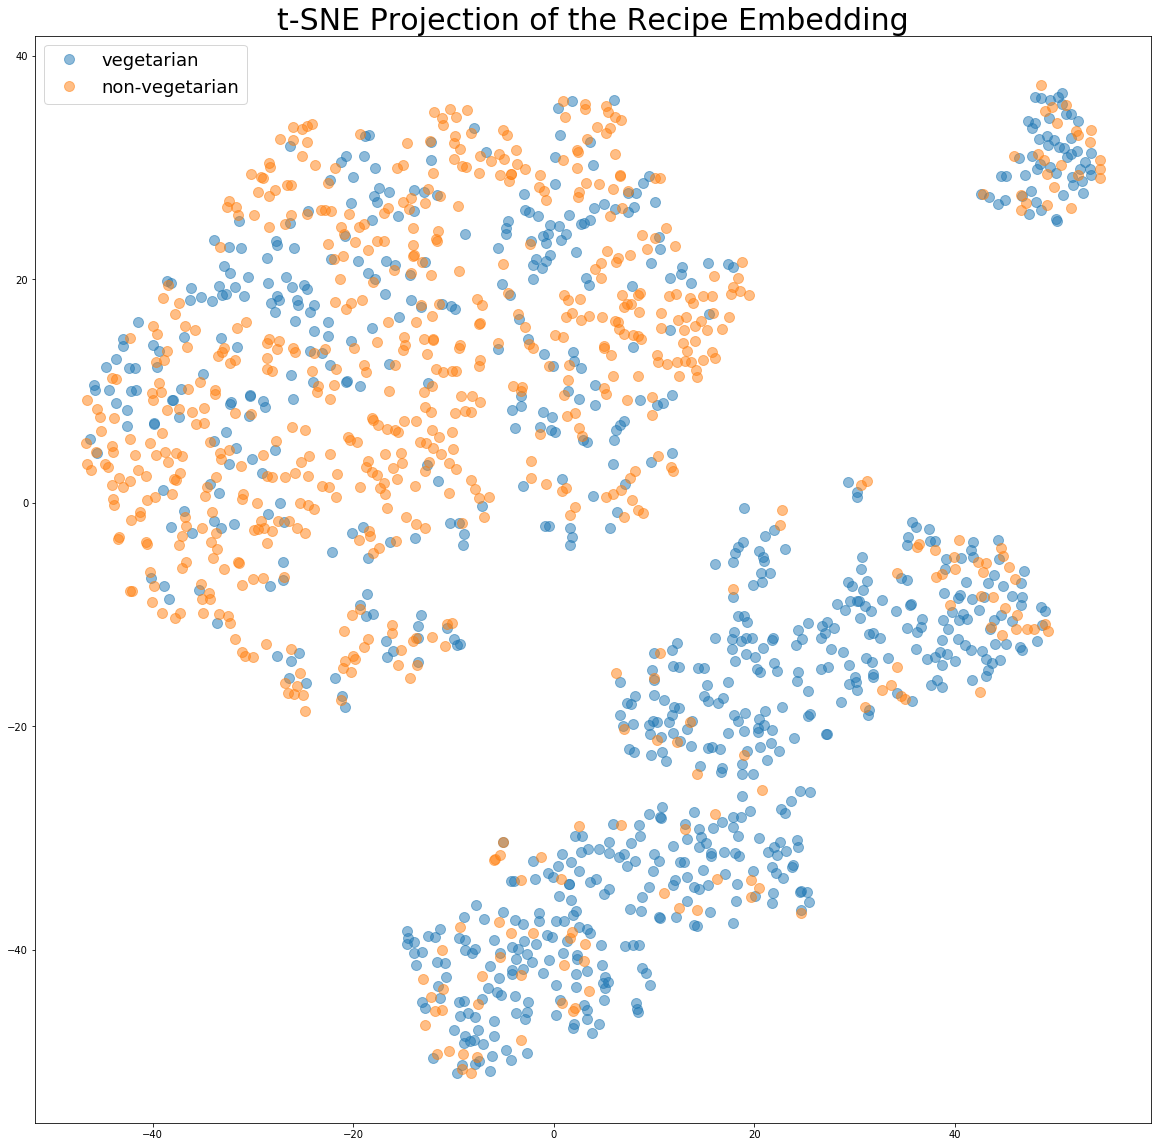

In [201]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.margins(0.05) 

zero_indices = np.where(recipe_all.diettype == 'vegetarian')[0]
one_indices = np.where(recipe_all.diettype == 'non-vegetarian')[0]

ax.plot(viz[zero_indices,0], viz[zero_indices,1], marker='o', linestyle='', 
        ms=10, alpha=0.5, label='vegetarian')
ax.plot(viz[one_indices,0], viz[one_indices,1], marker='o', linestyle='', 
        ms=10, alpha=0.5, label='non-vegetarian')
ax.legend()
plt.legend(loc='upper left',fontsize=18)
plt.title('t-SNE Projection of the Recipe Embedding', fontsize=30)
plt.show()

In [151]:
recipe_all.loc[recipe_all['cuisine'] != 'others']

,publishdate,content_id,title_en,cuisine,difficulty,mealtype,diettype,cooking_method,steps,ingredients,#ingredients,steps_length
0,2017-04-29,R702,Braised chicken with couscous,african,medium,main,non-vegetarian,"marinating,roasting,slow-cooking,steaming",Deglaze with some of the chicken stock. In the...,"['chicken legs', 'chicken stock (divided)', 'c...",18,158
1,2017-11-05,R943,Lamb and quince tagine,african,medium,main,non-vegetarian,NaN,Heat olive oil and butter in a tagine or large...,"['butter', 'cilantro for garnishing', 'ground ...",17,87
2,2018-07-24,R1295,East African-style coconut chicken,african,medium,main,non-vegetarian,sauteing,"Add the onions, garlic, and ginger to the pot ...","['canned crushed tomatoes', 'chicken legs', 'c...",18,220
3,2017-02-02,R574,Moroccan-inspired chickpea stew,african,easy,main,vegetarian,stewing,Add chickpeas to stew and let simmer for appro...,"['apple cider vinegar (optional)', 'black pepp...",29,188
4,2015-06-29,R256,Coleslaw with cranberries,american,easy,others,vegetarian,marinating,Finely chop parsley. Roughly chop cranberries....,"['buttermilk', 'cabbage', 'carrots', 'cranberr...",12,69
5,2015-06-29,R221,Classic cheesecake,american,easy,dessert,non-vegetarian,"baking,oven",Add cookie crumb mixture to a round baking for...,"['berries (e.g. raspberries', ' blueberries', ...",14,201
6,2018-10-17,R1264,5-ingredient Philly-style cheesesteak,american,easy,main,non-vegetarian,"grilling,sauteing","Add another drizzle of oil to the pan, then ad...","['baguette', 'bell peppers', 'cheddar cheese',...",8,206
7,2018-06-14,R1147,Millionaire bar cookies,american,easy,dessert,vegetarian,"baking,oven",Chop dark chocolate and melt in a heatproof bo...,"['baking powder', 'butter (divided)', 'dark ch...",11,236
8,2018-10-16,R1397,Honey caramel and salted peanut cookies,american,easy,dessert,vegetarian,"baking,oven",Preheat oven to 180°C/350°F. Using a hand mixe...,"['baking soda', 'brown sugar', 'butter (divide...",11,167
9,2015-04-29,R223,Salad in a jar,american,easy,main,non-vegetarian,grilling,"Grate Parmesan. Then, mix yogurt, lemon zest, ...","['bell pepper (red)', 'carrot', 'cherry tomato...",16,141


In [176]:
np.where(recipe_all.cuisine == uniq[0])[0]

array([1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512,
       1513])

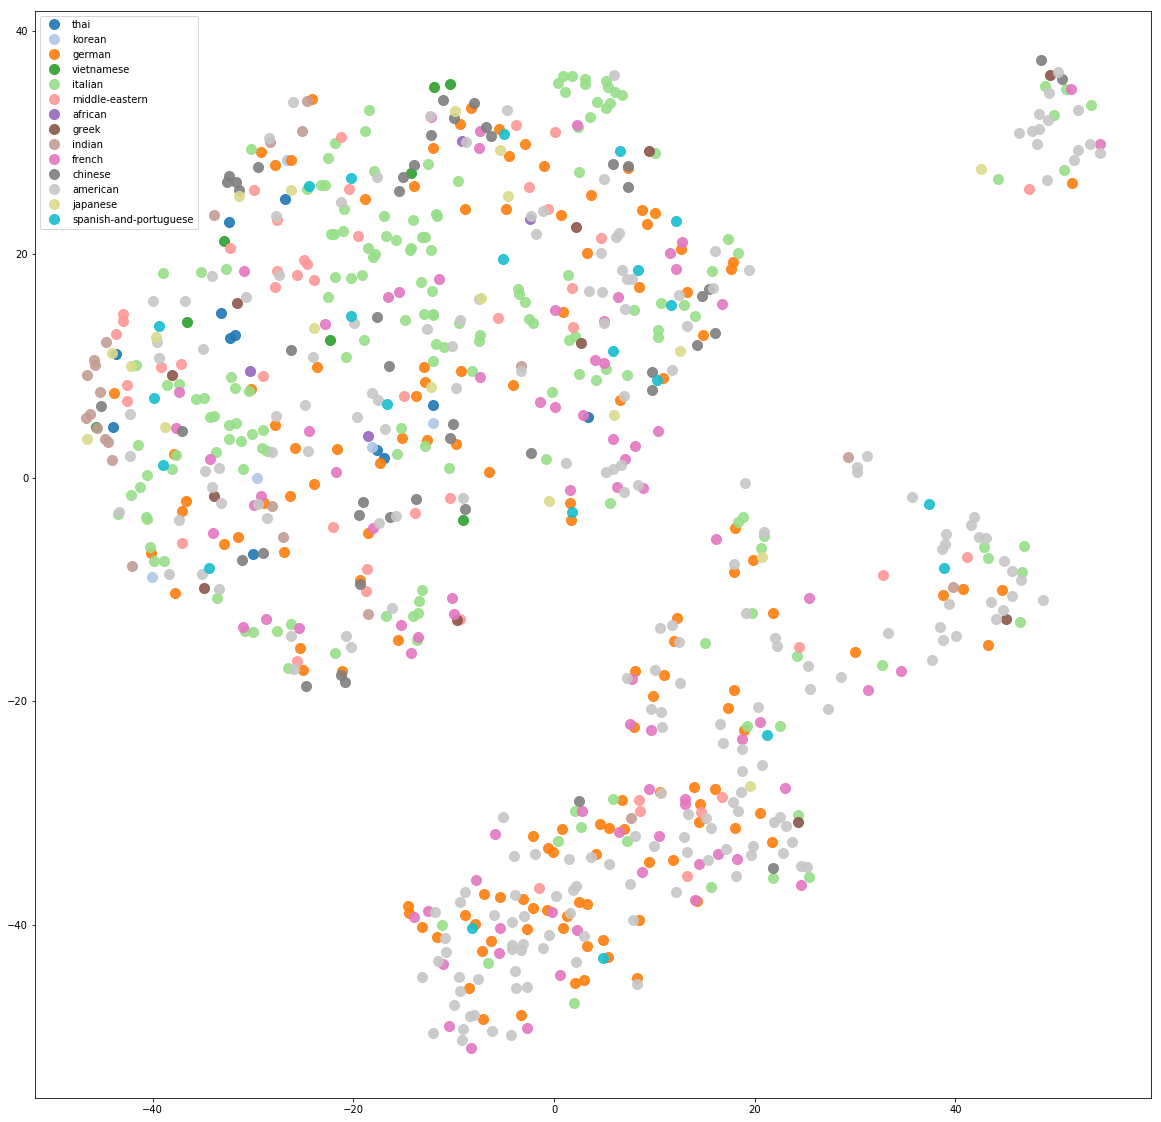

In [192]:
# fig, ax = plt.subplots()
# ax.margins(0.05) 
import matplotlib.colors as colors
import matplotlib.cm as cmx

# uniq = list(set(recipe_all.loc[recipe_all['cuisine'] != 'others'].cuisine))
# uniq
# len(uniq)

# for i in range(len(uniq)):
#     np.where(recipe_all.cuisine == uniq[i])[0]

z = range(1,len(uniq))
hot = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

fig, ax = plt.subplots()
ax.margins(0.05) 

for i in range(len(uniq)):
    indx = np.where(recipe_all.cuisine == uniq[i])[0]
#     plt.scatter(viz[indx,0], viz[indx,1], s=15, color=scalarMap.to_rgba(i), label=i)
    ax.plot(viz[indx,0], viz[indx,1], marker='o', linestyle='', ms=10, color=scalarMap.to_rgba(i), 
            alpha=0.9, label=uniq[i])

plt.legend(loc='upper left')

plt.show()